This notebook contains all the exploration steps taken during the **Adidas Data Science Case Study**, which are listed as follows:<br><br>
1) Preliminary Exploration<br>

2) Sales Forecasting<br>
1. Unified Single Model
2. Individual Models for Individual Articles

3) Feature Importance

P.S: As the case is extremely similar to the Rossmann Store Sales prediction Challenge on Kaggle, we have done thorough research on the solutions and discussions regarding that challenge and the forecasting models are largely inspired by the approaches chosen in Rossmann Challenge (e.g. [http://nbviewer.jupyter.org/github/JohanManders/ROSSMANN-KAGGLE/blob/master/ROSSMANN%20STORE%20SALES%20COMPETITION%20KAGGLE.ipynb](url_here),<br> [https://www.kaggle.com/blackbear2017/a-journey-through-rossmann-stores](url_here)).

# 1. Preliminary Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

1) Load the data:

In [2]:
sales = pd.read_csv('sales.txt', 
                    delimiter=';',
                    nrows=None,
                    parse_dates=['retailweek'],
                    date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

attributes = pd.read_csv('article_attributes.txt', delimiter=';')

2) Take a first look at the data:

In [3]:
sales.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0


In [4]:
attributes.head()

,article,productgroup,category,cost,style,sizes,gender,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col
0,OC6355,SHOES,TRAINING,13.29,slim,"xxs,xs,s,m,l,xl,xxl",women,205,104,57,255,187,255
1,AP5568,SHORTS,TRAINING,2.29,regular,"xxs,xs,s,m,l,xl,xxl",women,188,238,104,255,187,255
2,CB8861,HARDWARE ACCESSORIES,GOLF,1.70,regular,"xxs,xs,s,m,l,xl,xxl",women,205,173,0,255,187,255
3,LI3529,SHOES,RUNNING,9.00,regular,"xxs,xs,s,m,l,xl,xxl",kids,205,140,149,164,211,238
4,GG8661,SHOES,RELAX CASUAL,9.60,regular,"xxs,xs,s,m,l,xl,xxl",women,138,43,226,164,211,238


In [5]:
sales.shape

(81426, 9)

In [6]:
attributes.shape

(476, 13)

3) Check if there are missing values in the columns:

In [7]:
for col in sales.columns:
    print col+': '+str(sales[col].isnull().sum())

country: 0
article: 0
sales: 0
regular_price: 0
current_price: 0
ratio: 0
retailweek: 0
promo1: 0
promo2: 0


In [8]:
for col in attributes.columns:
    print col+': '+str(attributes[col].isnull().sum())

article: 0
productgroup: 0
category: 0
cost: 0
style: 0
sizes: 0
gender: 0
rgb_r_main_col: 0
rgb_g_main_col: 0
rgb_b_main_col: 0
rgb_r_sec_col: 0
rgb_g_sec_col: 0
rgb_b_sec_col: 0


4) See how many unique values there are for each columns in sales and attribute:

In [9]:
for col in sales.columns:
    print col+': '+str(len(sales[col].unique()))

country: 3
article: 477
sales: 785
regular_price: 123
current_price: 174
ratio: 5154
retailweek: 123
promo1: 2
promo2: 2


In [10]:
for col in attributes.columns:
    print col+': '+str(len(attributes[col].unique()))

article: 476
productgroup: 6
category: 21
cost: 118
style: 3
sizes: 8
gender: 4
rgb_r_main_col: 49
rgb_g_main_col: 75
rgb_b_main_col: 65
rgb_r_sec_col: 49
rgb_g_sec_col: 75
rgb_b_sec_col: 65


The results above tell us that there are only information about 476 articles in the attribute table where as we have sales history information for 477 articles.

In [11]:
set(sales['article'].unique())-set(attributes['article'].unique())

{'IO7646'}

5) Summarize the sales dataframe

In [12]:
sales.describe([.1,.2,.3,.6,.7,.8,.9,.95,.98,.99,.999])

,sales,regular_price,current_price,ratio,promo1,promo2
count,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000
mean,57.048375,52.620695,28.356811,0.544464,0.065041,0.005060
std,88.506045,35.549601,22.704746,0.192692,0.246599,0.070953
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000
10%,4.000000,14.950000,6.950000,0.308143,0.000000,0.000000
20%,8.000000,23.950000,9.950000,0.331942,0.000000,0.000000
30%,12.000000,27.950000,13.950000,0.393020,0.000000,0.000000
50%,26.000000,41.450000,20.950000,0.523526,0.000000,0.000000
60%,37.000000,53.950000,26.950000,0.592404,0.000000,0.000000
70%,53.000000,65.950000,32.950000,0.663866,0.000000,0.000000


6) As we are looking to predict the future sales, let us take a closer look at this feature next:

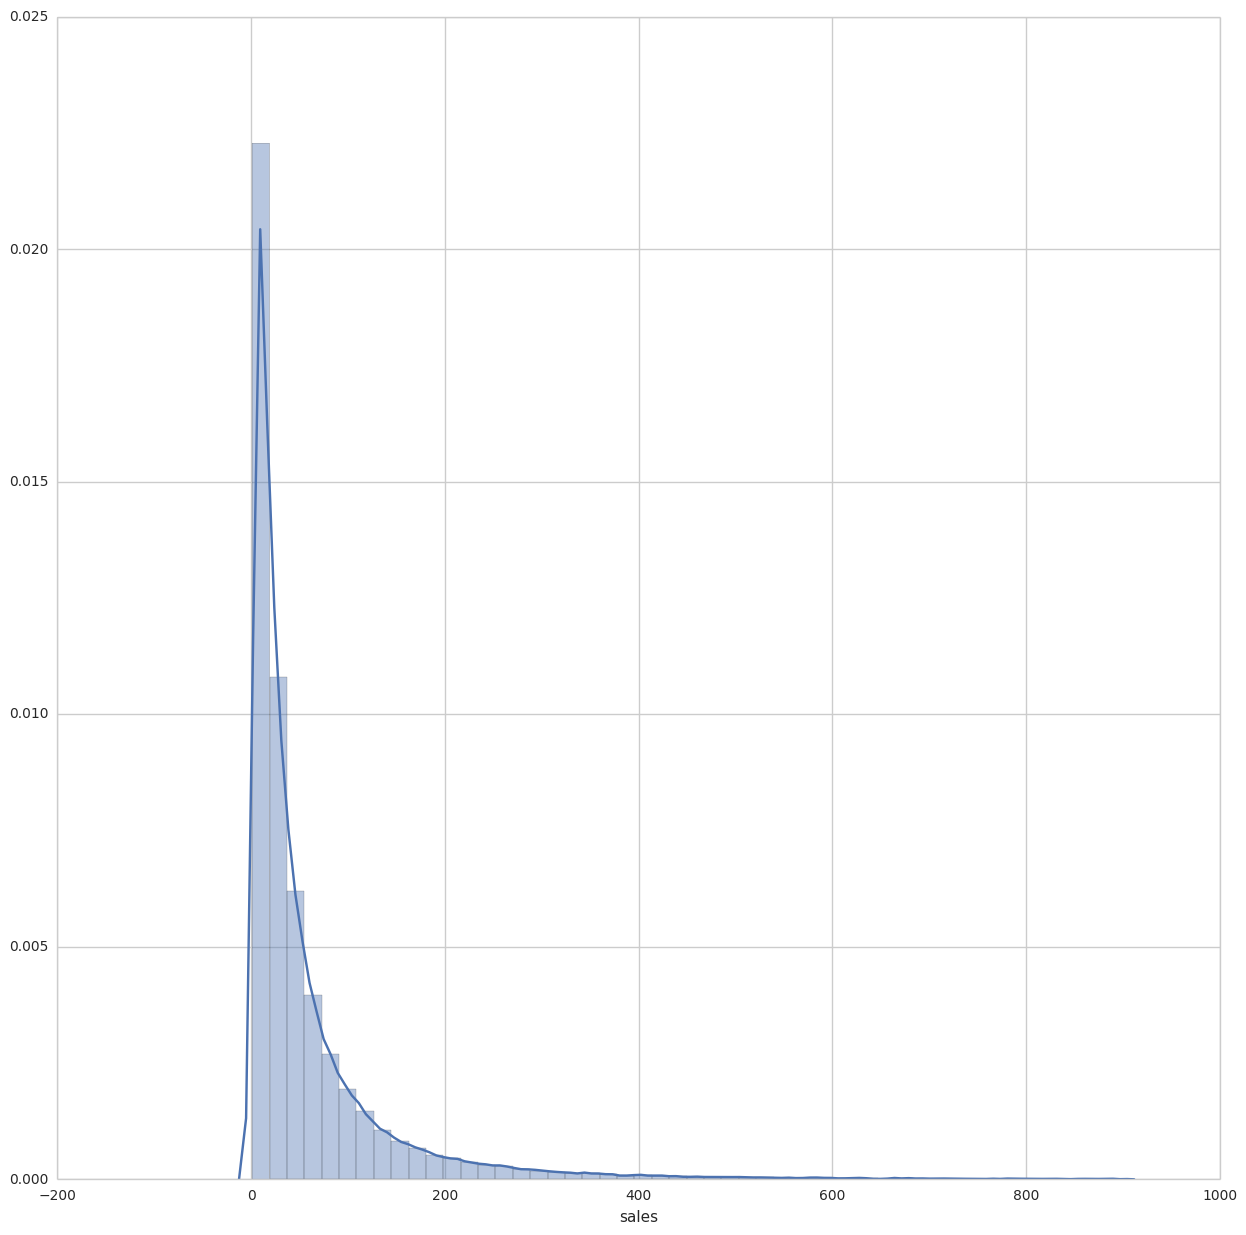

In [13]:
# plot the histogram for sales
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

sns.distplot(sales['sales'])

In [14]:
# group by date and get average sales, and precent change
average_sales    = sales.groupby('retailweek')["sales"].mean()
pct_change_sales = sales.groupby('retailweek')["sales"].sum().pct_change()

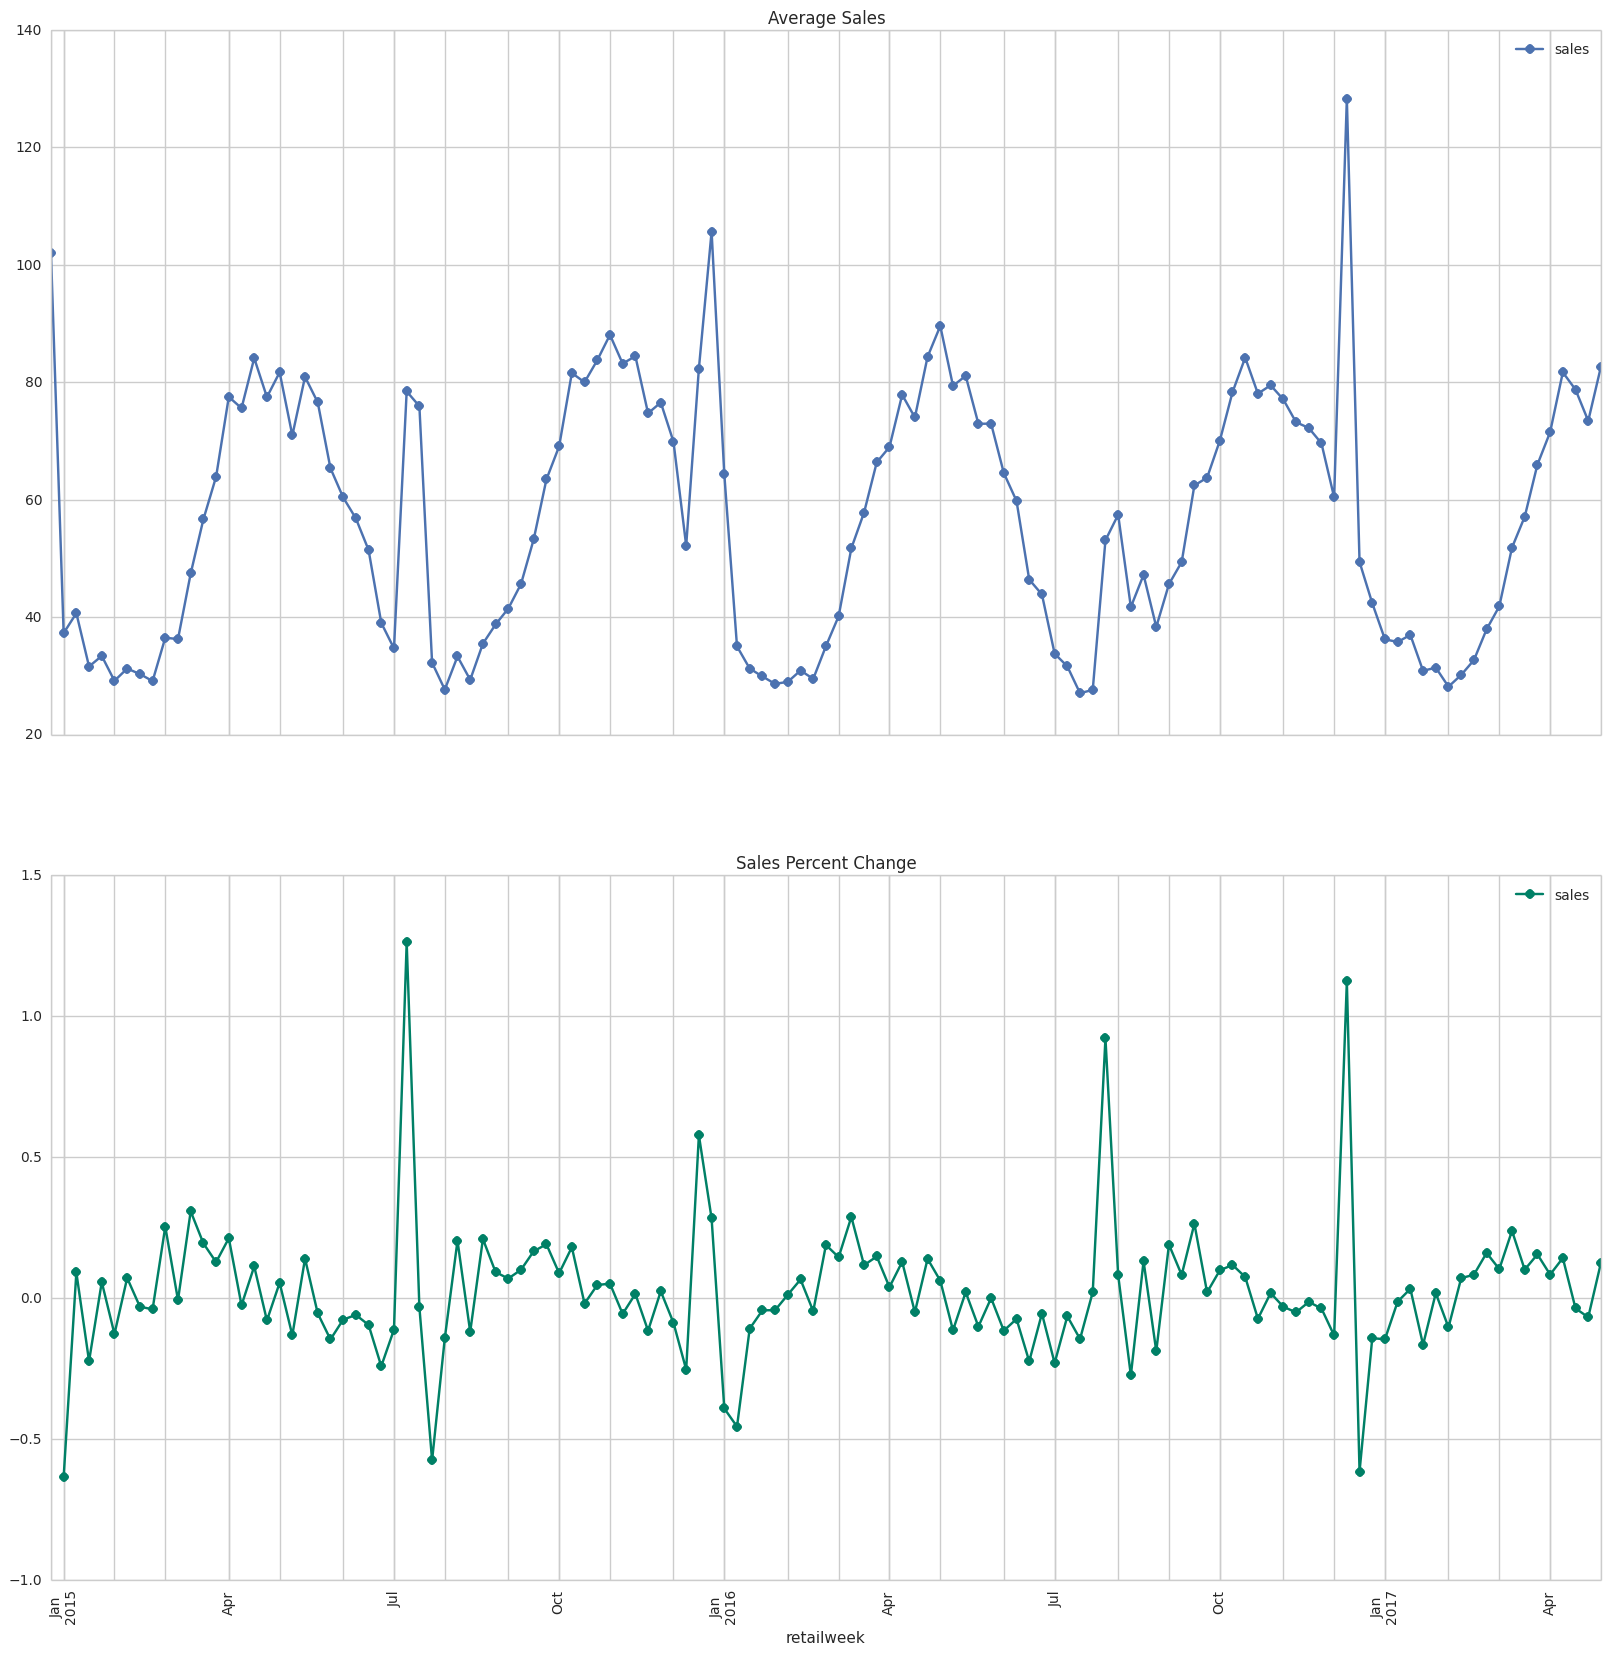

In [15]:
fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(20, 20))

# plot average sales over time(year-month)
ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

# plot precent change for sales over time(year-month)
ax2 = pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change")
# ax2.set_xticks(range(len(pct_change_sales)))
# ax2.set_xticklabels(pct_change_sales.index.tolist(), rotation=90)
# plt.tight_layout()

From the plot above we see that there are **strong signs of yearly seasonality** for the average sales.

7) To continue investigating the temporal characteristics of the column ['sales']:

In [16]:
sales['saleslog'] = np.log1p(sales['sales'])

features_x = ['regular_price', 'current_price', 'ratio', 'promo1', 'promo2']
features_y = ['saleslog']

var_name = 'retailweek'

sales['day'] = pd.Index(sales[var_name]).day
sales['week'] = pd.Index(sales[var_name]).week
sales['month'] = pd.Index(sales[var_name]).month
sales['year'] = pd.Index(sales[var_name]).year
sales['dayofyear'] = pd.Index(sales[var_name]).dayofyear

sales['day'] = sales['day'].fillna(0)
sales['week'] = sales['week'].fillna(0)
sales['month'] = sales['month'].fillna(0)
sales['year'] = sales['year'].fillna(0)
sales['dayofyear'] = sales['dayofyear'].fillna(0)

features_x.append('day')
features_x.append('week')
features_x.append('month')
features_x.append('year')
features_x.append('dayofyear')

In [17]:
sales.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,saleslog,day,week,month,year,dayofyear
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0,4.143135,28,52,12,2014,362
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0,3.401197,4,1,1,2015,4
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0,4.077537,11,2,1,2015,11
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0,3.912023,18,3,1,2015,18
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0,6.784457,25,4,1,2015,25


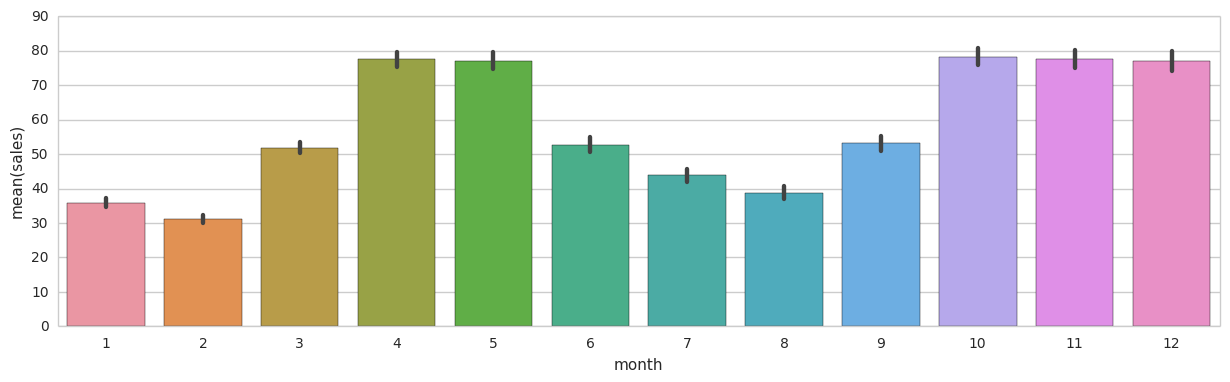

In [18]:
# plot the average sales for each month in the year
fig, axis = plt.subplots(1,1,figsize=(15,4))

sns.barplot(x='month', y='sales', data=sales, order=range(1, 13), ax=axis)

# won't plot the same for the yearly averages, as there are only 4 years available, 
# in which 2014 contains only one day of data, 2017 only the first 5 months 
# (therefore not a comprehensive yearly indicator).

The graph above shows that most sales happen in April, May, October, November and December.

8) Now turn to the two types of promotions:

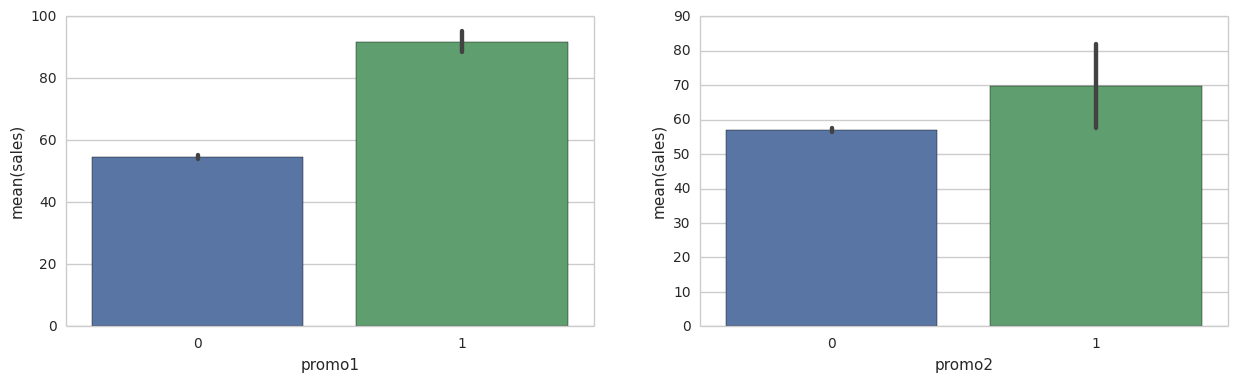

In [19]:
# plot average sales with/without promo1/promo2
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='promo1', y='sales', data=sales, ax=axis1)
sns.barplot(x='promo2', y='sales', data=sales, ax=axis2)

The plots above **seem** to indicate that **promo1 has a stronger impact on sales than promo2 does**. We will check in further detail later on during the forecasting model building process.

9) Now to see how the three countries are doing in terms of sales:

In [20]:
# group by date and get average sales (per country)
average_sales_DE = sales[sales['country']=='Germany'].groupby('retailweek')["sales"].mean()
average_sales_FR = sales[sales['country']=='France'].groupby('retailweek')["sales"].mean()
average_sales_AT = sales[sales['country']=='Austria'].groupby('retailweek')["sales"].mean()

average_sales_DE = average_sales_DE.to_frame()
average_sales_DE = average_sales_DE.merge(average_sales_FR.to_frame(), left_index=True, right_index=True)
average_sales_DE = average_sales_DE.merge(average_sales_AT.to_frame(), left_index=True, right_index=True)

average_sales_DE.columns = ['sales_DE', 'sales_FR', 'sales_AT']

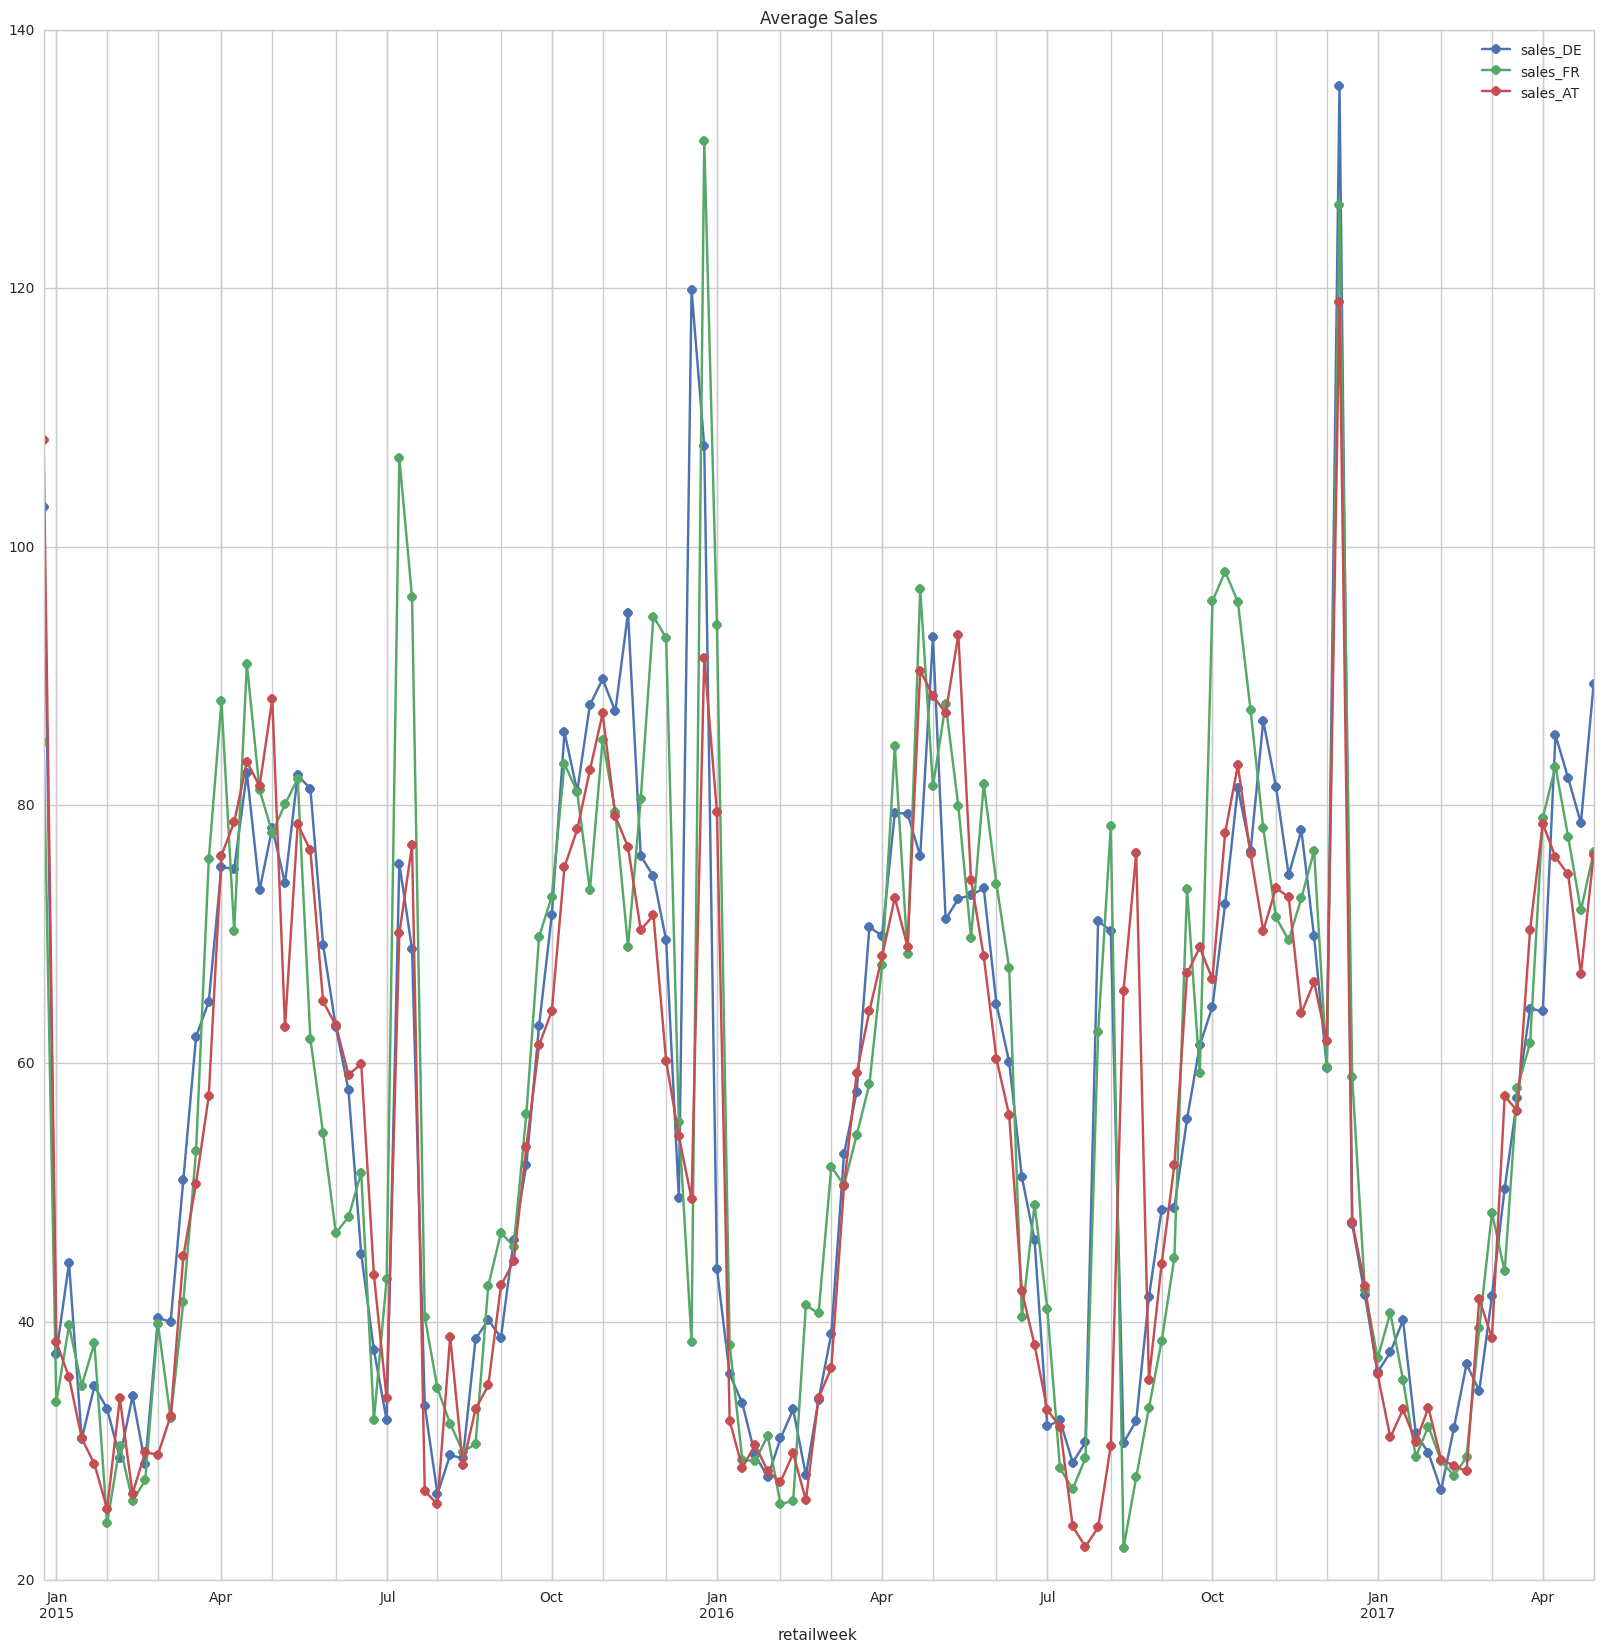

In [21]:
fig, axis = plt.subplots(1,1,sharex=True,figsize=(20, 20))
average_sales_DE.plot(legend=True,ax=axis,marker='o',title="Average Sales")

The time series above show that there are still strong signs of seasonality in each country and the sales in the three countries seem to be quite correlated.

10) Next we look at the relation between current/regular price ratio and sales:

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


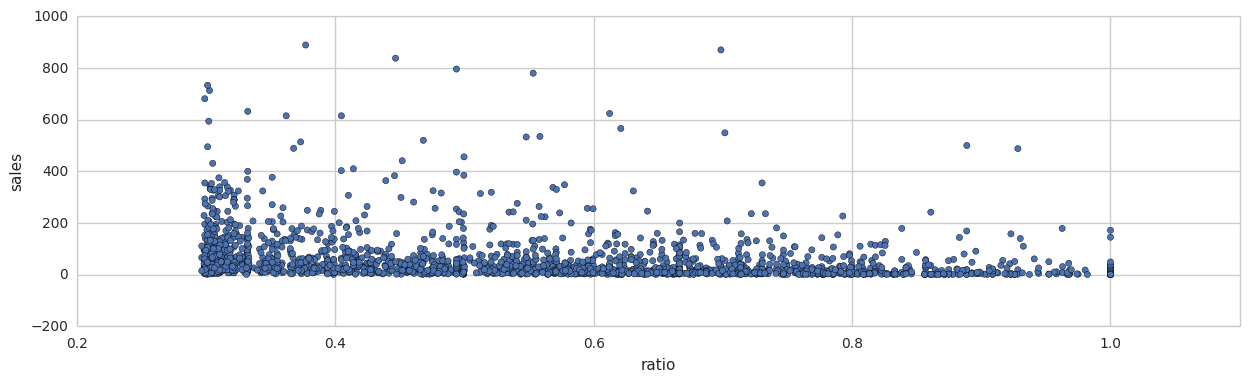

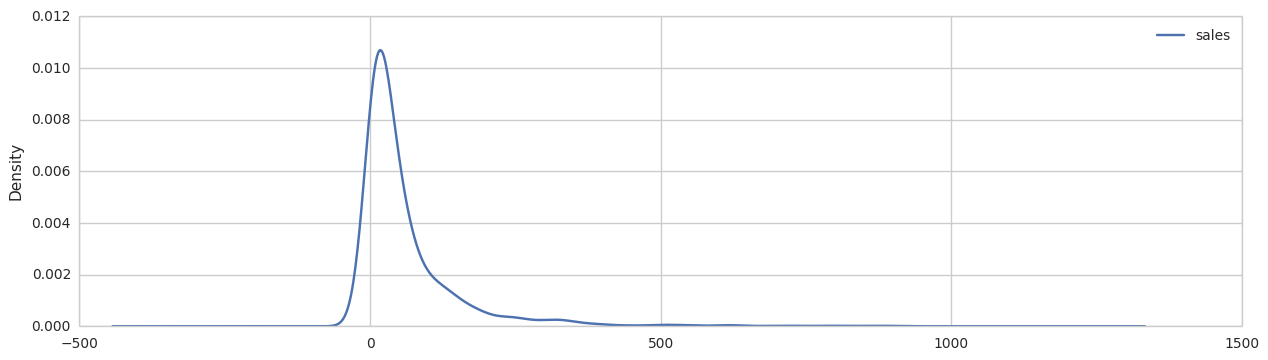

In [22]:
# select only a fraction in the sales dataset to avoid too much overlapping in the visualization.
sample_sales = sales.sample(n=2000)

# plot ratio vs sales
sample_sales.plot(kind='scatter',x='ratio',y='sales',figsize=(15,4))
sample_sales.plot(kind='kde',x='ratio',y='sales',figsize=(15,4))

The figures above tell us that, **in general, more articles will be sold when ratio is lower (higher discount).**

11) Afterwards, we briefly turn our attention to the attributes of the articles:

In [23]:
# join the two dataframes
data_merged = pd.merge(sales, attributes, on='article')

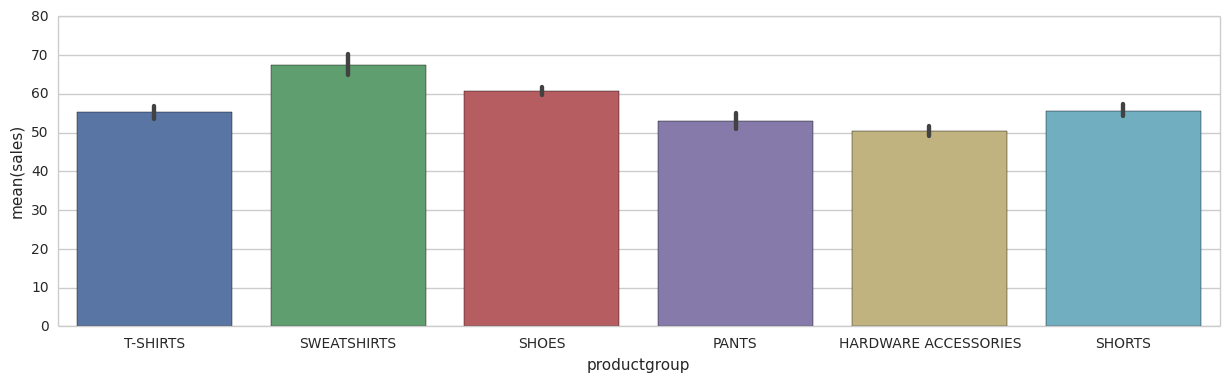

In [24]:
# plot the average sales for each product group
fig, axis = plt.subplots(1,1,figsize=(15,4))

sns.barplot(x='productgroup', y='sales', data=data_merged, order=data_merged['productgroup'].unique(), ax=axis)

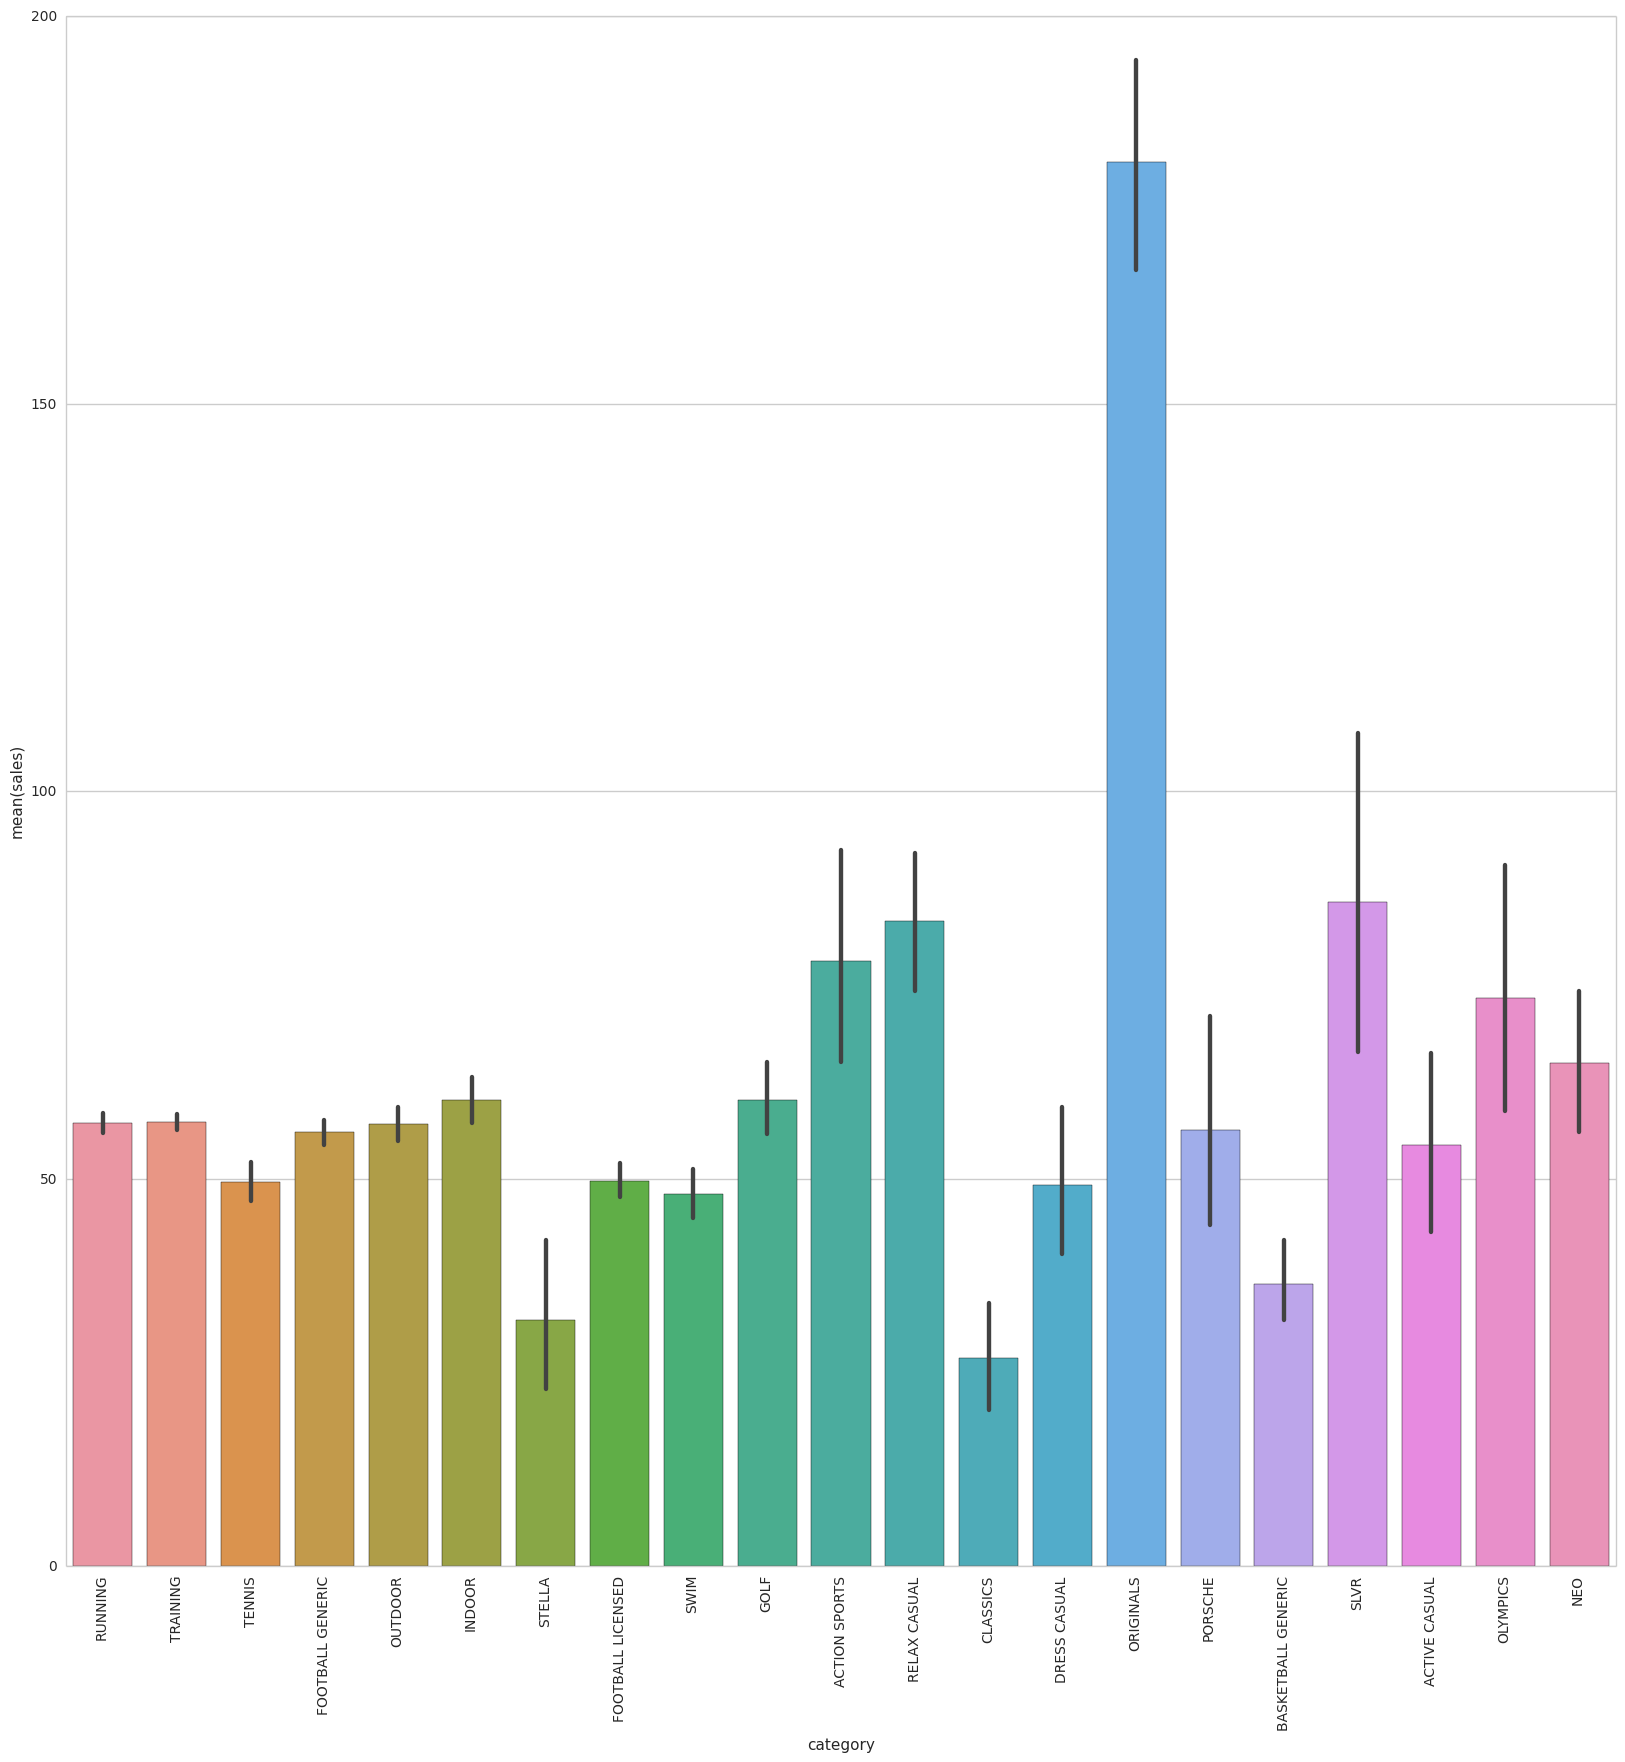

In [25]:
# plot the average sales for each category
fig, axis = plt.subplots(1,1,figsize=(20,20))

sns.barplot(x='category', y='sales', data=data_merged, order=data_merged['category'].unique(), ax=axis)
axis.set_xticks(range(len(data_merged['category'].unique())))
axis.set_xticklabels(data_merged['category'].unique(), rotation=90)
# plt.tight_layout()

Looks like Originals have been having the best performance during the investigated time period.

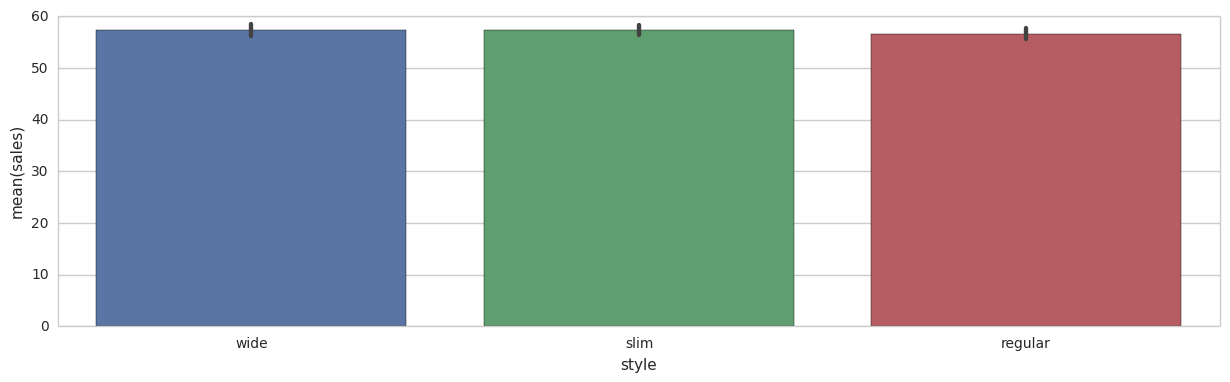

In [26]:
# plot the average sales for each style
fig, axis = plt.subplots(1,1,figsize=(15,4))

sns.barplot(x='style', y='sales', data=data_merged, order=data_merged['style'].unique(), ax=axis)
# plt.tight_layout()

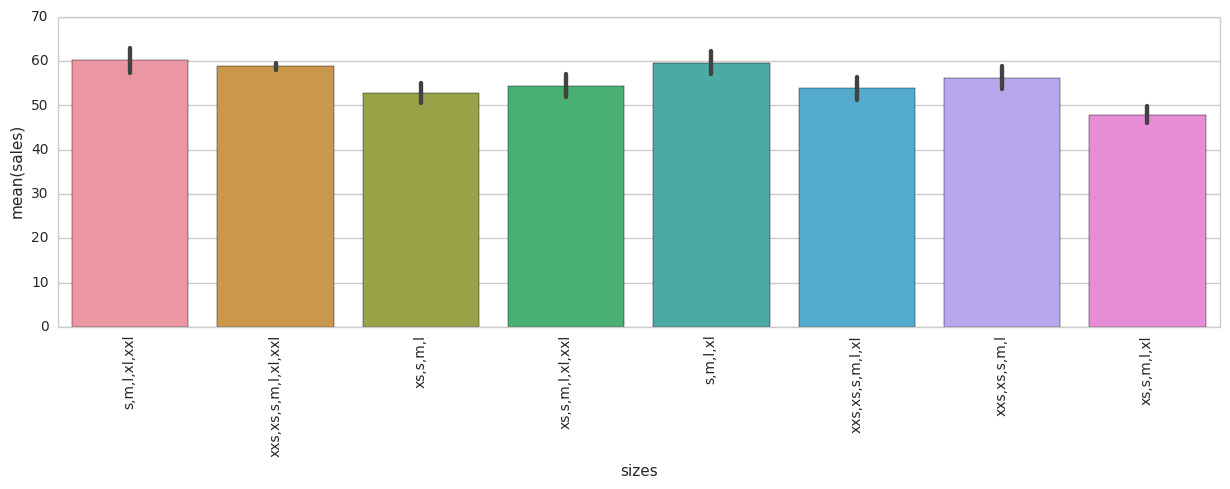

In [27]:
# plot the average sales for each size
fig, axis = plt.subplots(1,1,figsize=(15,4))

sns.barplot(x='sizes', y='sales', data=data_merged, order=data_merged['sizes'].unique(), ax=axis)
axis.set_xticks(range(len(data_merged['sizes'].unique())))
axis.set_xticklabels(data_merged['sizes'].unique(), rotation=90)

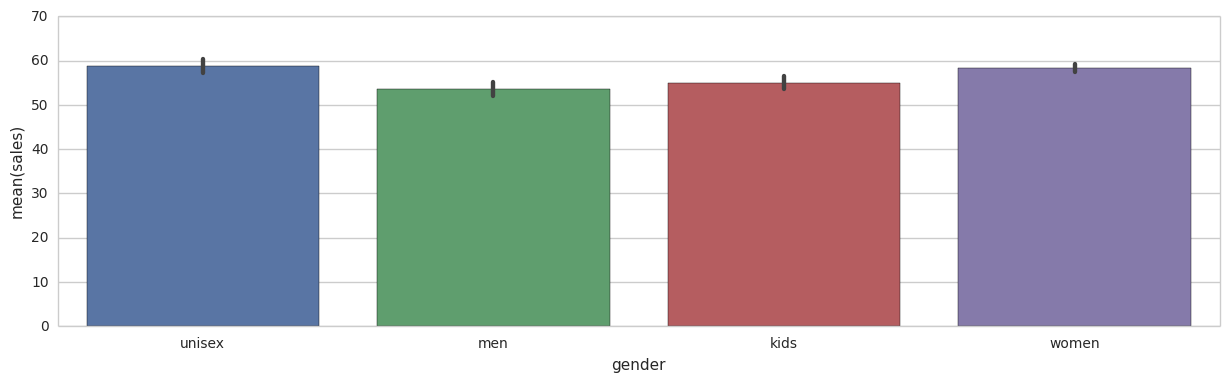

In [28]:
# plot the average sales for each gender
fig, axis = plt.subplots(1,1,figsize=(15,4))

sns.barplot(x='gender', y='sales', data=data_merged, order=data_merged['gender'].unique(), ax=axis)
# plt.tight_layout()

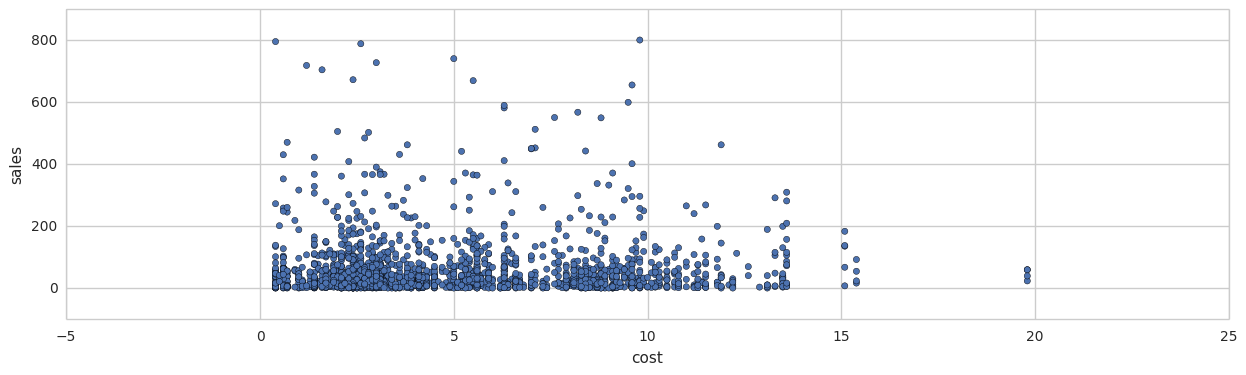

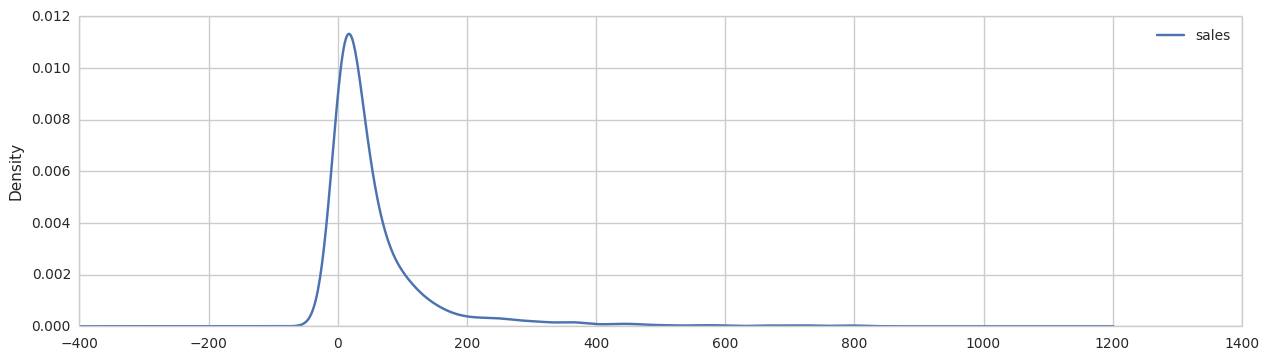

In [29]:
# select only a fraction in the merged dataset to avoid too much overlapping in the visualization.
sample_data_merged = data_merged.sample(n=2000)

# plot cost vs sales
sample_data_merged.plot(kind='scatter',x='cost',y='sales',figsize=(15,4))
sample_data_merged.plot(kind='kde',x='cost',y='sales',figsize=(15,4))

The figures above indicates that no distinctive correlation can be detected between cost and sales of an article.

12) To quantitatively demonstrate the points made above (about the correlation between cost/sales and ratio/sales), we also look at the correlation coefficient matrix for the merged dataframe:

In [30]:
data_merged.corr()

,sales,regular_price,current_price,ratio,promo1,promo2,saleslog,day,week,month,year,dayofyear,cost,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col
sales,1.000000,1.839857e-02,-0.102018,-0.257473,1.032704e-01,0.010210,0.757893,9.727623e-03,1.097161e-01,1.150608e-01,-3.430681e-02,1.146706e-01,2.733576e-02,-8.692605e-03,-1.123286e-02,-2.859477e-03,-8.862053e-03,-3.674605e-03,-8.659423e-03
regular_price,0.018399,1.000000e+00,0.842917,-0.042704,2.757147e-18,0.010322,0.028144,-7.077002e-19,5.967095e-18,8.213789e-19,-5.070203e-16,-4.270892e-19,9.430526e-01,1.001563e-02,1.175427e-02,6.518029e-02,-2.217077e-02,2.078498e-02,-2.281612e-02
current_price,-0.102018,8.429173e-01,1.000000,0.408878,6.875311e-02,0.022557,-0.168836,-1.805129e-03,-1.205519e-01,-1.369464e-01,1.455535e-02,-1.355333e-01,7.916877e-01,9.299222e-03,1.118976e-02,5.677453e-02,-1.658080e-02,1.812240e-02,-2.107814e-02
ratio,-0.257473,-4.270398e-02,0.408878,1.000000,1.518774e-01,0.028358,-0.432951,-3.462283e-03,-2.682422e-01,-3.050156e-01,3.342310e-02,-3.018112e-01,-4.497662e-02,9.482078e-03,5.208027e-03,-5.839153e-04,2.501528e-03,5.537633e-04,-1.021932e-03
promo1,0.103270,2.757147e-18,0.068753,0.151877,1.000000e+00,0.053529,0.101864,7.138038e-02,2.714865e-01,2.263260e-01,-1.445897e-01,2.302858e-01,-2.981691e-18,3.201197e-17,-9.816956e-18,1.258256e-17,-1.162790e-17,3.631505e-18,-1.268392e-17
promo2,0.010210,1.032208e-02,0.022557,0.028358,5.352861e-02,1.000000,-0.000978,-2.127831e-03,2.269971e-03,-5.448422e-02,4.240758e-03,-5.426282e-02,-1.102974e-02,-8.498218e-03,-3.497621e-03,-1.231976e-02,2.999731e-03,6.981287e-03,6.044518e-03
saleslog,0.757893,2.814366e-02,-0.168836,-0.432951,1.018636e-01,-0.000978,1.000000,1.411107e-02,1.645125e-01,1.749880e-01,-4.341565e-02,1.742522e-01,3.964386e-02,-9.950026e-03,-2.305887e-02,1.352046e-03,-2.159966e-02,-6.008028e-03,-5.386834e-03
day,0.009728,-7.077002e-19,-0.001805,-0.003462,7.138038e-02,-0.002128,0.014111,1.000000e+00,3.021985e-02,3.519927e-02,-1.594895e-02,1.167348e-01,-2.401988e-18,2.801806e-18,-2.720620e-19,-3.167656e-18,-4.963556e-18,-1.429804e-18,-3.518867e-18
week,0.109716,5.967095e-18,-0.120552,-0.268242,2.714865e-01,0.002270,0.164512,3.021985e-02,1.000000e+00,9.120859e-01,-2.866282e-01,9.091003e-01,9.910704e-18,-8.537649e-18,-4.102257e-18,6.705762e-18,1.655064e-17,-3.464684e-18,6.586394e-18
month,0.115061,8.213789e-19,-0.136946,-0.305016,2.263260e-01,-0.054484,0.174988,3.519927e-02,9.120859e-01,1.000000e+00,-3.338445e-01,9.966314e-01,9.701922e-18,9.777766e-18,9.588506e-18,7.905193e-18,-3.613158e-18,-1.242823e-17,-3.004508e-18


The matrix above also shows that promo1 has stronger correlation with sales in comparison to promo2.

The information about the main and secondary colors of an article will for now be omitted in the analysis. Nontheless, if need be, we could find out about the relation between the colors and sales by doing the following data transformation: <br>
1) convert rgb pairs for main and secondary colors to color description in string/one-hot-key(integer) format,<br>
2) conduct the same kinds of analysis as shown above.

# 2. Sales Forecasting

Two types of forecasting models will be trained and their forecasting performance will be evaluated on the Mean Absolute Percentage Error (MAPE): <br>1) Unified model (xgboost) on all articles. <br> 2) Separate models on individual articles.

FYI, the evaluation criteria here will be MAPE, as it won't be affected by the magnitude of the values to be predicted and shows intuitively how far off the prediction models are.

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# defining the evaluation criteria
def rmse(y, yhat):
    return np.sqrt(np.mean((yhat - y) ** 2))

def rmse_xg(yhat, y):
    y = np.array(y.get_label())
    yhat = np.array(yhat)
    return "rmse", rmse(y,yhat)

def rmspe(y,yhat):
    return np.sqrt(np.mean( ((y-yhat) / y)**2 ) )

def rmspe_xg(yhat, y):
    y = np.array(y.get_label())
    yhat = np.array(yhat)
    return "rmspe", rmspe(y,yhat)

def mape(y,yhat):
    return np.mean( np.abs((y-yhat) / y) )

def mape_xg(yhat, y):
    y = np.array(y.get_label())
    yhat = np.array(yhat)
    return "mape", mape(y,yhat)

1. Unified Single Model:
---

In [32]:
for col in list(data_merged.select_dtypes(include=['object']).columns):
    data_merged[col+'_numeric'] = pd.Categorical(data_merged[col])
    data_merged[col+'_numeric'] = data_merged[col+'_numeric'].cat.codes
    features_x.append(col+'_numeric')
    
for col in ['cost', 
            'rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col', 
            'rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col']:
    features_x.append(col)

Splitting the data into training and testing parts (last month for testing, the rest for training):

In [33]:
train = data_merged[data_merged['retailweek']<'2017-03-31']
test = data_merged[data_merged['retailweek']>'2017-03-31']

# first 80% of training data will be used for model training, the rest for validation
X_train, X_valid = train_test_split(train, test_size=0.2, random_state=10)
y_train = np.array(X_train[features_y])
y_valid = np.array(X_valid[features_y])
dtrain = xgb.DMatrix(X_train[features_x], y_train)
dvalid = xgb.DMatrix(X_valid[features_x], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

seed = 2017

Now to tune the parameters of xgboost model:

In [65]:
y = X_train[features_y]
X = X_train[features_x]

# first tune max_depth and min_child_weight
print("Parameter optimization")
y = X_train[features_y]
X = X_train[features_x]
xgb_model = xgb.XGBRegressor()

param_test1 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}

clf = GridSearchCV(xgb_model,
                   param_test1, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.1min finished


0.38370569515
{'max_depth': 7, 'min_child_weight': 1}


In [66]:
y = X_train[features_y]
X = X_train[features_x]

# locate the precise setting for max_depth
print("Parameter optimization")
y = X_train[features_y]
X = X_train[features_x]
xgb_model = xgb.XGBRegressor()

param_test2 = {
    'max_depth': range(6, 9, 1)
}

clf = GridSearchCV(xgb_model,
                   param_test2, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   18.9s finished


0.385082028277
{'max_depth': 8}


In [67]:
y = X_train[features_y]
X = X_train[features_x]

# tune gamma
print("Parameter optimization")
y = X_train[features_y]
X = X_train[features_x]
xgb_model = xgb.XGBRegressor(max_depth=8, min_child_weight=1)

param_test3 = {
    'gamma': [i / 10.0 for i in range(0, 5)]
}

clf = GridSearchCV(xgb_model,
                   param_test3, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   42.9s finished


0.386498834828
{'gamma': 0.3}


In [68]:
y = X_train[features_y]
X = X_train[features_x]

# tune subsample and colsample_bytree
print("Parameter optimization")
y = X_train[features_y]
X = X_train[features_x]
xgb_model = xgb.XGBRegressor(max_depth=8, min_child_weight=1, gamma=0.3)

param_test4 = {
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)]
}

clf = GridSearchCV(xgb_model,
                   param_test4, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.9min finished


0.388129005108
{'subsample': 0.9, 'colsample_bytree': 0.8}


In [69]:
y = X_train[features_y]
X = X_train[features_x]

# tune subsample and colsample_bytree more accurately
print("Parameter optimization")
y = X_train[features_y]
X = X_train[features_x]
xgb_model = xgb.XGBRegressor(max_depth=8, min_child_weight=1, gamma=0.3)

param_test5 = {
    'subsample': [i / 100.0 for i in range(85, 100, 5)],
    'colsample_bytree': [i / 100.0 for i in range(75, 90, 5)]
}

clf = GridSearchCV(xgb_model,
                   param_test5, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.3min finished


0.38843245567
{'subsample': 0.95, 'colsample_bytree': 0.75}


In [70]:
y = X_train[features_y]
X = X_train[features_x]

# tune the regularization parameter reg_alpha
print("Parameter optimization")
y = X_train[features_y]
X = X_train[features_x]
xgb_model = xgb.XGBRegressor(max_depth=8, min_child_weight=1, gamma=0.3, subsample=0.95, colsample_bytree=0.75)

param_test6 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 10, 100]
}

clf = GridSearchCV(xgb_model,
                   param_test6, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   43.4s finished


0.390430942379
{'reg_alpha': 10}


In [71]:
y = X_train[features_y]
X = X_train[features_x]

# tune reg_alpha more accurately
print("Parameter optimization")
y = X_train[features_y]
X = X_train[features_x]
xgb_model = xgb.XGBRegressor(max_depth=8, min_child_weight=1, gamma=0.3, subsample=0.95, colsample_bytree=0.75)

param_test7 = {
    'reg_alpha': [5, 10, 20, 50, 100]
}

clf = GridSearchCV(xgb_model,
                   param_test7, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

Parameter optimization
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   32.7s finished


0.390430942379
{'reg_alpha': 10}


In [34]:
#XGboost params
params1 = {"objective": "reg:linear",
          "booster" : "gbtree",
          "n_estimators": 500,
          "eta": 0.1,
          "gamma": 0.3,
          "max_depth": 8,
          "min_child_weight": 1,
          "max_delta_step": 0,
          "subsample": 0.95,
          "colsample_bytree": 0.75,
#           "colsample_bylevel": 0.8,
          "lambda": 0,
          "alpha": 10,
          "silent": 1,
          "thread": 4,
          "seed": seed
          }

num_boost_round = 1000

# Training the tree:
gbm = xgb.train(params1, dtrain, num_boost_round, evals=watchlist,
                early_stopping_rounds=100, feval=mape_xg, verbose_eval=True)

print("Make predictions on the test set")
dtest = xgb.DMatrix(test[features_x])
test_preds = gbm.predict(dtest)

error = mape(np.array(test[features_y]), np.array(test_preds))
print('MAPE: {:.6f}'.format(error))


[0]	train-rmse:2.78965	eval-rmse:2.80279	train-mape:0.711579	eval-mape:0.711612
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 100 rounds.
[1]	train-rmse:2.55715	eval-rmse:2.57107	train-mape:0.636464	eval-mape:0.636074
[2]	train-rmse:2.35183	eval-rmse:2.36662	train-mape:0.572427	eval-mape:0.571977
[3]	train-rmse:2.17133	eval-rmse:2.18677	train-mape:0.519995	eval-mape:0.520189
[4]	train-rmse:2.01329	eval-rmse:2.02957	train-mape:0.477514	eval-mape:0.47821
[5]	train-rmse:1.875	eval-rmse:1.89177	train-mape:0.443785	eval-mape:0.444614
[6]	train-rmse:1.75453	eval-rmse:1.7718	train-mape:0.41693	eval-mape:0.418167
[7]	train-rmse:1.65044	eval-rmse:1.66816	train-mape:0.395874	eval-mape:0.397445
[8]	train-rmse:1.56101	eval-rmse:1.57927	train-mape:0.380257	eval-mape:0.382384
[9]	train-rmse:1.48345	eval-rmse:1.50215	train-mape:0.367983	eval-mape:0.370559
[10]	train-rmse:1.41673	eval-rmse:1.43592	train-mape:0.358694

2. Individual Models for Individual Articles:
---

Splitting the data into training and testing parts like with single model, but this time only using sales information (last month for testing, the rest for training):

In [35]:
train_individual = sales[sales['retailweek']<'2017-03-31']
test_individual = sales[sales['retailweek']>'2017-03-31']

In [36]:
# Loop through each country/article pair, 
# train the model using the data of current article, and predict its sales values for the month of April.

train_dic = dict(list(train_individual.groupby(['country','article'])))
test_dic     = dict(list(test_individual.groupby(['country','article'])))
scores       = []
test_y_l = []
test_preds_l = []

for i in train_dic:
    
    # current article
    article = train_dic[i]
    
    # define training and testing sets
    X_train = article.drop(["sales","article", 'saleslog', 'retailweek', 'country'],axis=1)
    Y_train = article[features_y]
    
    article_test  = test_dic[i]
    X_test = article_test.drop(["sales","article", 'saleslog', 'retailweek', 'country'],axis=1)
    Y_test = article_test[features_y]
    
    # Linear Regression
    lreg = LinearRegression()
    lreg.fit(X_train, Y_train)
    
    # calculate the error score: MAPE
    Y_pred = lreg.predict(X_test)
    scores.append(mape(np.array(Y_test), np.array(Y_pred)))
    test_y_l.extend(np.array(Y_test))
    test_preds_l.extend(np.array(Y_pred))

In [37]:
error = mape(test_y_l, np.array(test_preds_l))
print('MAPE: {:.6f}'.format(error))

MAPE: 0.268947


In [39]:
# Loop through each country/article pair, 
# train the model using the data of current article, and predict its sales values for the month of April.

train_dic = dict(list(train_individual.groupby(['country','article'])))
test_dic     = dict(list(test_individual.groupby(['country','article'])))
scores       = []
test_y_l = []
test_preds_l = []

for i in train_dic:
    
    # current article
    article = train_dic[i]
    
    # define training and testing sets
    X_train = article.drop(["sales","article", 'saleslog', 'retailweek', 'country'],axis=1)
    Y_train = article[features_y]
    
    article_test  = test_dic[i]
    X_test = article_test.drop(["sales","article", 'saleslog', 'retailweek', 'country'],axis=1)
    Y_test = article_test[features_y]
    
    # Linear Regression
    rfreg = AdaBoostRegressor()
    rfreg.fit(X_train, Y_train)
    
    # calculate the error score: MAPE
    Y_pred = rfreg.predict(X_test)
    scores.append(mape(np.array(Y_test), np.array(Y_pred)))
    test_y_l.extend(np.array(Y_test))
    test_preds_l.extend(np.array(Y_pred))

/home/jc/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
len(test_preds_l)

3310

In [43]:
error = mape(test_y_l, np.array(test_preds_l))
print('MAPE: {:.6f}'.format(error))

MAPE: 0.325325


In [38]:
# Loop through each country/article pair, 
# train the model using the data of current article, and predict its sales values for the month of April.

train_dic = dict(list(train_individual.groupby(['country','article'])))
test_dic     = dict(list(test_individual.groupby(['country','article'])))
scores       = []
test_y_l = []
test_preds_l = []

features_x_individual = ['regular_price', 'current_price', 'ratio', 'promo1', 'promo2', 'day',
                         'week', 'month', 'year','dayofyear']

#XGboost params
params1 = {"objective": "reg:linear",
          "booster" : "gbtree",
          "n_estimators": 500,
          "eta": 0.1,
          "gamma": 0.3,
          "max_depth": 8,
          "min_child_weight": 1,
          "max_delta_step": 0,
          "subsample": 0.95,
          "colsample_bytree": 0.75,
#           "colsample_bylevel": 0.8,
          "lambda": 0,
          "alpha": 10,
          "silent": 1,
          "thread": 4,
          "seed": seed
          }

num_boost_round = 1000

for i in train_dic:
    
    # current article
    article = train_dic[i]
    
    # first 80% of training data will be used for model training, the rest for validation
    X_train, X_valid = train_test_split(article, test_size=0.2, random_state=10)
    y_train = np.array(X_train[features_y])
    y_valid = np.array(X_valid[features_y])
    dtrain = xgb.DMatrix(X_train[features_x_individual], y_train)
    dvalid = xgb.DMatrix(X_valid[features_x_individual], y_valid)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    # Training the tree:
    gbm = xgb.train(params1, dtrain, num_boost_round, evals=watchlist,
                    early_stopping_rounds=100, feval=mape_xg, verbose_eval=False)

#     print("Make predictions on the test set")
    dtest = xgb.DMatrix(article_test[features_x_individual])
    test_preds = gbm.predict(dtest)

    error = mape(np.array(article_test[features_y]), np.array(test_preds))
#     print('MAPE: {:.6f}'.format(error))

    scores.append(error)
    test_y_l.extend(np.array(Y_test))
    test_preds_l.extend(np.array(Y_pred))

In [39]:
error = mape(test_y_l, np.array(test_preds_l))
print('MAPE: {:.6f}'.format(error))

MAPE: 0.245694


Finally, we select the second type of model as it seems to make better predictions. To forecast the sales for the following month(2017-05), information such as ratio, regular_price, promo1, promo2, ratio need to be gathered beforehand. As it is not yet available, other time series prediction based models will be more suitable such as ARIMA/LSTM (the 123 weeks/28 months, excluding the first month - 2014-12, of sales as input time series to forecast the next month). 

# 3. Feature Importance

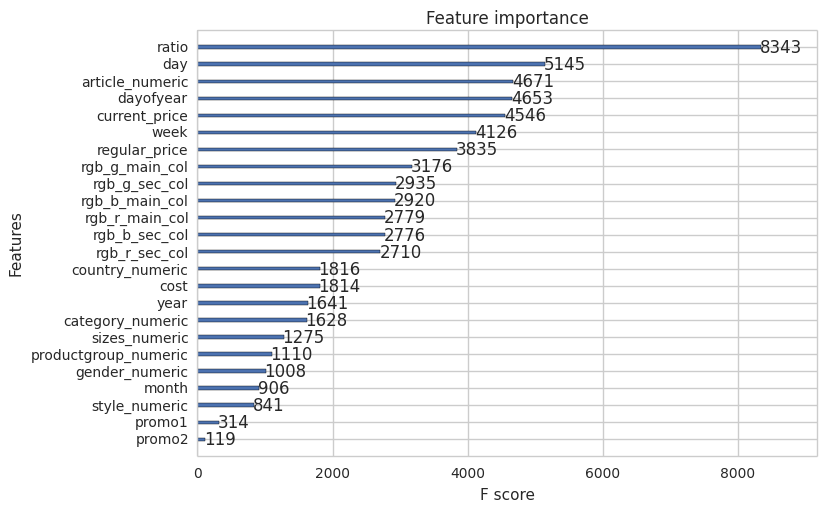

In [35]:
xgb.plot_importance(gbm)

To save the feature importance figure:

In [36]:
from plt_save import save
def my_plot_importance(model, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(model, ax=ax, **kwargs)

In [37]:
my_plot_importance(gbm, [15,15])
save("feature_importance", ext="pdf", close=True, verbose=True)

Saving figure to './feature_importance.pdf'... Done


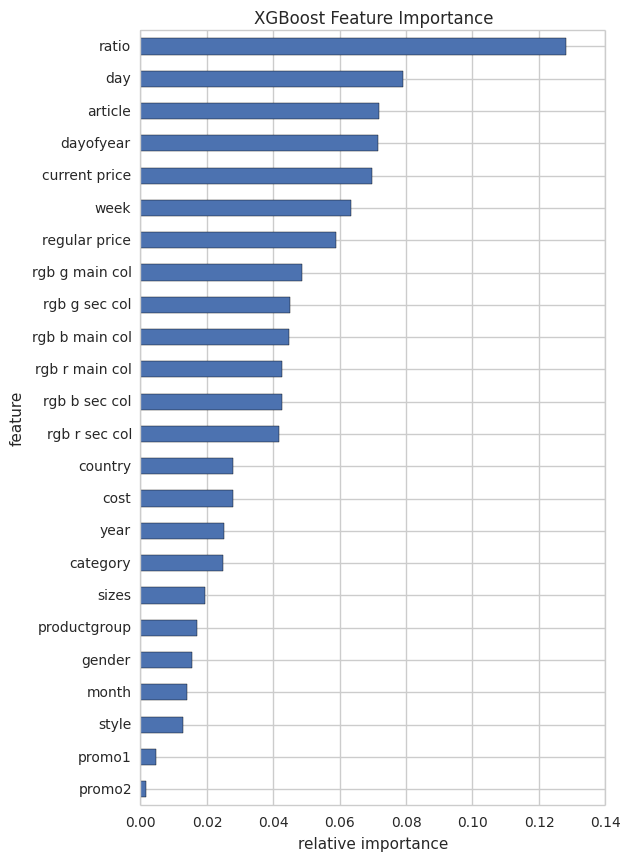

In [40]:
import operator

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
create_feature_map(features_x)

importance = gbm.get_fscore(fmap='xgb.fmap')

importance = { x.replace('_numeric', ''): importance[x] for x in importance.keys() }
importance = { x.replace('_', ' '): importance[x] for x in importance.keys() }

importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()

Save the feature importance for top 7 and last 7 features

In [43]:
from plt_save import save
df_top7 = df[df['fscore']>0.05]
df_last7 = df[df['fscore']<0.02]

featp = df_top7.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 6))
# plt.title('Feature Importance (Top 7)')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
fig_featp = featp.get_figure()
save("feature_importance_top7", ext="png", close=True, verbose=True)


featp = df_last7.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 6))
# plt.title('Feature Importance (Last 7)')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
fig_featp = featp.get_figure()
save("feature_importance_last7", ext="png", close=True, verbose=True)

Saving figure to './feature_importance_top7.png'... Done
Saving figure to './feature_importance_last7.png'... Done


From the feature importance plot above we can spot out the main driving factors for sales (ratio between current/regular price, article id, regular_price, current price, day of year, day in the week, week etc.). Interestingly, the color of an article has contributed to sales as well. **The plot also demonstrates once again that promo1 has a larger impact on sales than promo2 does.** 

# Notes:

Some future work to be done with this task:<br>

1) Just like in Rossmann Challenge, we can feed in other external information if we have other features available. For example, the interest rate in a nation, temperature in a region (if we have geographical location information), etc. Here however, we choose to focus on the presented features to detect the main driving factors for the sales that are controllable by the company, i.e. Adidas in our case.<br>
2) The models in the groupby look for the articles can be fine-tuned and improved. Moreover, we tried xgboost individually but didn't achieve better results than linear regression as it usually takes more training data to properly train a xgboost model. However, if we have more training data for longer time period, the accuracy of the models can definitely be improved to a further extend.<br>
3) Predict the general sales in the whole dataset for the entire article set or for individual nations with other time series prediction models, such as LSTM/(LSTM+Gaussian Process).

If you have any questions regarding any detail on the analysis above or about the .pdf summary, feel free to contact me per Skype (**jiacheng.yao07**) or per Email: [jc07.yao@gmail.com]()

Thank you very much for taking the time to review the notebook!